Make code reproducible

In [1]:
import os
import random
import numpy as np
import tensorflow as tf

seed_value = 42

os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

Load and split the data. Print random sample

In [13]:
!pip install pandas
!pip install matplotlib
!pip install keras

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


Image class: 6


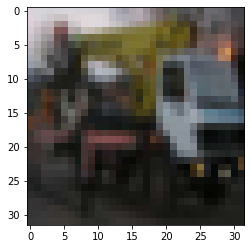

Dataset shape: (42000, 32, 32, 3)


In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from random import randint

from sklearn.model_selection import train_test_split

X = np.load('xs.npy')
y = np.load('ys.npy')

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

for i in range(1):
    print('Image class: {}'.format(y_train[a]))
    a = randint(0, len(x_train))
    plt.imshow(x_train[a])
    plt.show()

print('Dataset shape: {}'.format(x_train.shape))

Import tensorflow library and necessary tools

In [15]:
from tensorflow.python import keras
from tensorflow.keras import layers

from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization, Activation, GlobalAveragePooling2D, Lambda
from keras.models import Sequential
from keras.optimizers import SGD, Adam, Nadam, RMSprop
from keras.regularizers import l2

from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

from keras.layers.experimental.preprocessing import Resizing

from tensorflow.distribute import MirroredStrategy
from tensorflow.keras.applications import EfficientNetB1

from keras import regularizers
from keras.initializers import he_normal

Model

In [16]:
def make_model():
    weight_decay = 0.0005
    class_num = 9
    
    inputs = keras.Input(shape = (32, 32, 3))

    resize = Resizing(240, 240, interpolation="bilinear")(inputs)
    preprocess_input = Lambda(keras.applications.efficientnet.preprocess_input)(resize)

    convLayers = EfficientNetB1(
        include_top = False, 
        weights = 'imagenet',
        input_tensor = preprocess_input,
        pooling = None,
        classes = class_num, 
        classifier_activation = 'softmax'
    )

    convLayers.trainable = False
    x = convLayers.output
    
    x = Dense(512, kernel_regularizer=regularizers.l2(weight_decay))(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(class_num, activation = 'softmax')(x)

    model = keras.Model(convLayers.input, x)
    return model

In [21]:
# For multi-device synchronous training
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    model = make_model()
    model.compile(optimizer=Nadam(1e-4),
                  loss = 'sparse_categorical_crossentropy',
                  metrics = ['accuracy'])

early_stopping = EarlyStopping(monitor = 'val_accuracy',
                               patience = 10,
                               restore_best_weights = True)

lr_schedule = ReduceLROnPlateau(monitor='val_accuracy',
                                factor = 0.3,
                                patience = 6)

model.fit(x = x_train, y = y_train,
          validation_split = 0.1,
          epochs = 20,
          verbose = 2,
          batch_size = 128,
          callbacks = [early_stopping, lr_schedule])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Epoch 1/20
296/296 - 51s - loss: 1.0604 - accuracy: 0.7667 - val_loss: 0.7299 - val_accuracy: 0.8829
Epoch 2/20
296/296 - 38s - loss: 0.7450 - accuracy: 0.8638 - val_loss: 0.6441 - val_accuracy: 0.8990
Epoch 3/20
296/296 - 38s - loss: 0.6791 - accuracy: 0.8771 - val_loss: 0.5983 - val_accuracy: 0.9090
Epoch 4/20
296/296 - 38s - loss: 0.6257 - accuracy: 0.8886 - val_loss: 0.5694 - val_accuracy: 0.9114
Epoch 5/20
296/296 - 38s - loss: 0.5912 - accuracy: 0.8948 - val_loss: 0.5387 - val_accuracy: 0.9157
Epoch 6/20
296/296 - 38s - loss: 0.5537 - accuracy: 0.9010 - val_loss: 0.5147 - val_accuracy: 0.9157
Epoch 7/20
296/296 - 38s - loss: 0.5225 - accuracy: 0.9067 - val_loss: 0.4940 - val_accuracy: 0.9186
Epoch 8/20
296/296 - 38s - loss: 0.5009 - accuracy: 0.9105 - val_loss: 0.4737 - val_accuracy: 0.9181
Epoch 9/20
296/296 - 38s - loss: 0.4750 - accuracy: 0.9125 - val_loss: 0.4572 - val_accura

In [23]:
print(model.evaluate(x_test, y_test))

329/329 [==============================] - 12s 36ms/step - loss: 0.3590 - accuracy: 0.9227
[0.35899457335472107, 0.9226666688919067]


In [25]:
# Unfreeze and train fist 55 and last 5 layers of ImageNet
def unfreeze_model(model):
    for layer in model.layers[-55:5]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(optimizer=optimizer, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

unfreeze_model(model)
epochs = 10
model.fit(x = x_train, y = y_train, epochs = epochs, validation_split = 0.1, verbose=2)

Epoch 1/10
1182/1182 - 59s - loss: 0.3195 - accuracy: 0.9346 - val_loss: 0.3419 - val_accuracy: 0.9295
Epoch 2/10
1182/1182 - 47s - loss: 0.3084 - accuracy: 0.9370 - val_loss: 0.3359 - val_accuracy: 0.9293
Epoch 3/10
1182/1182 - 47s - loss: 0.2964 - accuracy: 0.9383 - val_loss: 0.3286 - val_accuracy: 0.9286
Epoch 4/10
1182/1182 - 47s - loss: 0.2842 - accuracy: 0.9426 - val_loss: 0.3275 - val_accuracy: 0.9286
Epoch 5/10
1182/1182 - 47s - loss: 0.2748 - accuracy: 0.9434 - val_loss: 0.3204 - val_accuracy: 0.9305
Epoch 6/10
1182/1182 - 47s - loss: 0.2626 - accuracy: 0.9476 - val_loss: 0.3205 - val_accuracy: 0.9271
Epoch 7/10
1182/1182 - 47s - loss: 0.2554 - accuracy: 0.9485 - val_loss: 0.3157 - val_accuracy: 0.9307
Epoch 8/10
1182/1182 - 47s - loss: 0.2531 - accuracy: 0.9471 - val_loss: 0.3089 - val_accuracy: 0.9310
Epoch 9/10
1182/1182 - 47s - loss: 0.2427 - accuracy: 0.9508 - val_loss: 0.3041 - val_accuracy: 0.9283
Epoch 10/10
1182/1182 - 47s - loss: 0.2361 - accuracy: 0.9509 - val_loss:

In [26]:
print("Accuracy with unfreeze layers: {}".format(model.evaluate(x_test, y_test)))

329/329 [==============================] - 12s 35ms/step - loss: 0.3199 - accuracy: 0.9241
Accuracy with unfreeze layers: [0.31985658407211304, 0.9240952134132385]


In [27]:
model.save('model.h5')